# Welcome to AST3003S Project Tutorial

In [11]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np

## Step 1

Read the fits file obtained from observations using the TFTO radio telescope and then extract the spectra from it. The fits file consists of 2 HDU Tables. Only the second one is required. The first one just contains some things from the manufacturer that is not relevant for us. 

In [17]:
tstfile='l_297_b_-15/20210912-060233_SPECTRUM-PROJ01-GAL_01#_01#.fits'

hdulist=fits.open(tstfile)
hdr=hdulist[1].header
data=hdulist[1].data

hdulist.info()

Filename: l_297_b_-15/20210912-060233_SPECTRUM-PROJ01-GAL_01#_01#.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1                1 BinTableHDU     82   30R x 11C   ['1D', '1D', '1D', '1D', '1D', '1D', '1D', '1024K', '1024K', '4A', '16A']   


The HDU table has two objects. The header and the data.

In [18]:
print(repr(hdulist[1].header))

XTENSION= 'BINTABLE'           / Table Extension                                
BITPIX  =                    8 / Binary data                                    
NAXIS   =                    2 / Two_dimensional table array                    
NAXIS1  =                16460 / Bytes per row (16460)                          
NAXIS2  = 30                     / NAXIS2 is ydimension of table array          
PCOUNT  =                    0 / Number of bytes following data matrix          
GCOUNT  =                    1 / Only one group                                 
TFIELDS =                   11 / Number of columns in the table                 
TFORM1  = '1D        '           / 1 double precision fp #8 bytes               
TTYPE1  = 'JD        '           / Julian Day                                   
TUNIT1  = 'd         '           / Days                                         
TFORM2  = '1D        '           / 1 double precision fp #8 bytes               
TTYPE2  = 'Azimuth   '      

In [19]:
print(data.columns)
print(data['RIGHT_POL'])
print(data['STATUS'])

ColDefs(
    name = 'JD'; format = '1D'; unit = 'd'
    name = 'Azimuth'; format = '1D'; unit = 'deg'
    name = 'Elevation'; format = '1D'; unit = 'deg'
    name = 'Az_Offset'; format = '1D'; unit = 'deg'
    name = 'El_Offset'; format = '1D'; unit = 'deg'
    name = 'Gal_Long'; format = '1D'; unit = 'deg'
    name = 'Gal_Lat'; format = '1D'; unit = 'deg'
    name = 'LEFT_POL'; format = '1024K'; unit = 'count'
    name = 'RIGHT_POL'; format = '1024K'; unit = 'count'
    name = 'STATUS'; format = '4A'
    name = 'MARKER'; format = '16A'
)
[[ 14958365  68406685  67674813 ... 180027764 179036318         0]
 [ -1836321  -7231503  76859269 ... 186316319 180438458         0]
 [-41727528   2428564  61441348 ... 333566479 335916797         0]
 ...
 [-22124792   7088276  44375932 ... 180023865 179774974         0]
 [ 20531562  59652860  44883208 ... 176039016 185165354         0]
 [  9204267  90564775  71900962 ... 326649815 318402522         0]]
['on' 'off' 'cal' 'on' 'off' 'cal' 'on' 'off' '

As you can see, the data contains all these columns. We take what we need and stack them to obtain a composite spectra. The status column has 20 'on' & 'off' entries and 10 'cal' entries. The cal entries have to be discarded.

## Step 2

Read all the files and stack to get the composite spectra. There are many ways to do this. I am doing it all in a single loop. The general idea is:
From each file, stack all the RIGHT POL if the STATUS is not cal. Do this for all the files. In total you should have (20 * 10s)* 3 = 600s exposure.

DIAMETER =                    3  / TELESCOPE diameter                            [astropy.io.fits.card]


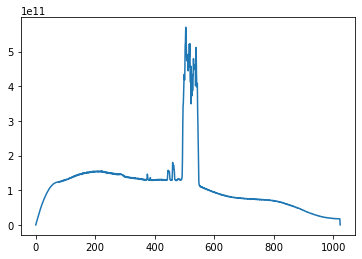

In [1]:
path=str(os.getcwd())+'/l_297_b_-15/'
files=os.listdir(path)

stack=np.zeros(1024)

for file in files:
    hdulist=fits.open(path+file)
    hdr=hdulist[1].header
    data=hdulist[1].data 
    for col in data:
        if col['STATUS'] != 'cal':
            stack+=col['RIGHT_POL']

plt.plot(stack) 
plt.show()            

## Step 3

Obtain the y_scale from the calibration data for setting a Brightness Temperature scale. Note that the big feature is some sort of noise. What we are interested in is the smaller feature before the noise.

Before getting the scale factor, make sure to do a continuum subtraction. (Subtract the mean of the stack from the stack)

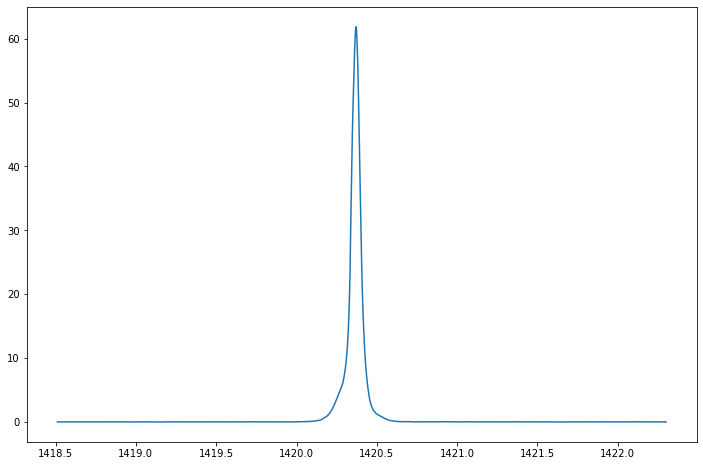

In [21]:
bonn_calib=np.loadtxt('bonn_l_207_b_-15.txt',skiprows = 4)
#print(bonn_calib)

bonn_x = bonn_calib[:,2]
bonn_y = bonn_calib[:,1]
bonn_v = bonn_calib[:,0]

#print(bonn_x.size)

plt.plot(bonn_x, bonn_y)

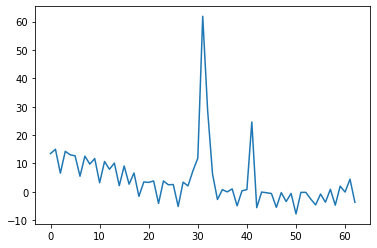

In [3]:
low=344
high=407

y_calib=stack-np.mean(stack[386:442])
y_scale=max(bonn_y)/max(y_calib[low:high])
y_calib=y_calib*y_scale

plt.plot(y_calib[low:high])

#print(np.argmax(bonn_y))
#print(np.argmax(y_calib[low:high]))
#print(y_calib[low:high].size)


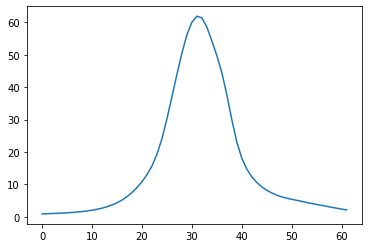

In [4]:
''' Lesson in Resolution matching '''

plt.plot(bonn_y[395-31:395+31])
#print(np.argmax(bonn_y[395-31:395+31]))
#print(bonn_y[395-31:395+31].size)

#61 kHz resolution for Obs and 5 kHz for calib
#Central freq = 1428.75 MHz, 1024 Channels, and Bandwidth = 62.5 MHz

The above plot shows the calibration spectra after slicing to get the same number of channels as the data. It is clear that this naive approach will not work because of the difference in resolution. The calibration spectra has a much higher resolution. If it has to be compared directly with the data, then it has to be rebinned to the same resolution.

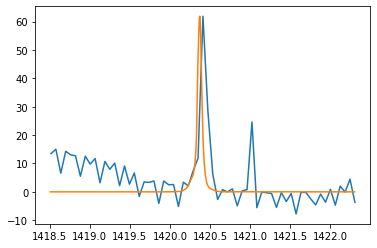

In [5]:
xdata=np.linspace(1397.5,1460,1024)

plt.plot(xdata[low:high],y_calib[low:high])
plt.plot(bonn_x,bonn_y)

#print(xdata[low:high][31])

## Step 4

Correcting for LSR. Use the code provided and change the Observatory location, Ra, Dec etc. All of which is there in the header file. You obtain the sky frequency from the code which when subtracted from rest frequency gives the x_shift seen in the above plot.

In [6]:
"""
vlsr_calc is a routine to do LSR corrections for radio astronomy using Astropy
In addition to the routine itself some examples of its usage are given
Author: Wolfgang Herrmann, Astropeiler Stockert
Version 1.1, August 7th, 2021
"""

#Required imports
from datetime import datetime
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
from astropy.coordinates import ICRS, LSR

"""
Here comes the routine to do the calculation
Required inputs:
obs_lon: Geographic longitude of the observatory in decimal degrees
obs_lat: Geographic latitude of the observatory in decimal degrees
obs_ht: Heigt of the observatory in meters
ra: Right ascension of the observed sky location in decimal hours
dec: Declination of the observed sky location in decimal degrees
time: Time of observation in UTC (Astropy format)
Note that there is a specific definiton of the peculiar motion of the sun
overriding the default.
This routine returns two values: The velocity of the observer with respect to
the solar system barycenter and the velocity of the observer with respect to
the local standard of rest.
"""
def vlsr_calc(obs_lon, obs_lat, obs_ht, ra, dec, time):
    obsloc = EarthLocation(lon=obs_lon*u.deg, lat=obs_lat*u.deg, height=obs_ht*u.m)
    skycoord = SkyCoord((ra*15.)*u.deg, dec*u.deg)
    vbary = skycoord.radial_velocity_correction(kind='barycentric', obstime=time, location=obsloc)  
    my_observation = ICRS((ra*15.)*u.deg, dec*u.deg, pm_ra_cosdec=0*u.mas/u.yr, pm_dec=0*u.mas/u.yr, \
    radial_velocity=vbary, distance = 1*u.pc)
    vlsr = my_observation.transform_to(LSR(v_bary=(10.27,15.32,7.74)*u.km/u.s)).radial_velocity
    return vbary,vlsr

#Now let's make an example how to use it
    
#Define the observatory location
#This example uses the coordinates of the Stockert observatory
obs_lon = -33.933101
obs_lat = 18.476483
obs_ht  = 25


#Define the sky location observed
ra = 5.79035955212443
dec = -1.67588307745559

#Define the time of observation
#If you want to take the current time:
#now = datetime.utcnow()
#time=Time(now, scale='utc')

#Here is an example on how to give an explicit time
#Uncomment of you want to use this example
mytime = '2021-09-12T06:16:58'
time=Time(mytime, scale='utc')


#Throw this into the calculation and print
velocities = vlsr_calc(obs_lon, obs_lat, obs_ht, ra, dec, time)
print ("Example 1")
print ("VLSR: ",velocities[1])
print ("Barycentric velocity:", velocities[0])

#You will notice that it is printed with units
#This is because the velocities are returned as Astropy entities.
#You may want to have this as simple floating point numbers:
vlsr = velocities[1].value
vbary = velocities[0].value/1000.
print ("Same as pure numbers in km/s: ",vlsr,vbary)
print("***")

#Your may want to use this to convert frequencies. For this we need the
#speed of light and the rest frequency.
c=299792.458    #speed of light in km/s
rest_frequency = 1420.40575177 #Hydrogen line in MHz

#This example calculates the sky frequency of the hydrogen rest frequency.
#You could use this to adjust your receiver frequency to record spectra in the LSR frame
sky_frequency = rest_frequency *(1-vlsr/c)
print ("Example 3")
print ("Sky frequency of a hydrogen line at rest:", sky_frequency)
print("***")

#Another example is to determine the LSR velocity of a line observed without correction:
#So let's assume you have some hydrogen line at 1420.412 MHz
#observed_frequency=sky_frequency
observed_frequency = 1420.412
LSR_velocity=c*(1-(observed_frequency/rest_frequency))-vlsr
print ("Example 4")
print("LSR velocity:", LSR_velocity)

Example 1
VLSR:  9.337118112079054 km / s
Barycentric velocity: 26898.394650158076 m / s
Same as pure numbers in km/s:  9.337118112079054 26.898394650158075
***
Example 3
Sky frequency of a hydrogen line at rest: 1420.3615128443118
***
Example 4
LSR velocity: -10.65587666227012


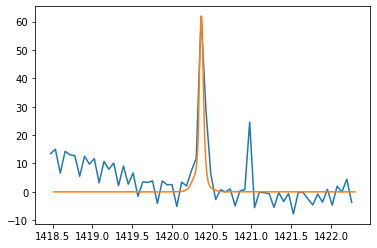

In [7]:
HI_rest=1420.40575177

x_shift=HI_rest-1420.3615128443118
xlsr=xdata-x_shift
xdatav=(300000)*((HI_rest-xlsr)/HI_rest)

plt.plot(xlsr[low:high],y_calib[low:high])
plt.plot(bonn_x,bonn_y)

## Step 5

Do a neat plot with labels, legend, title, etc..

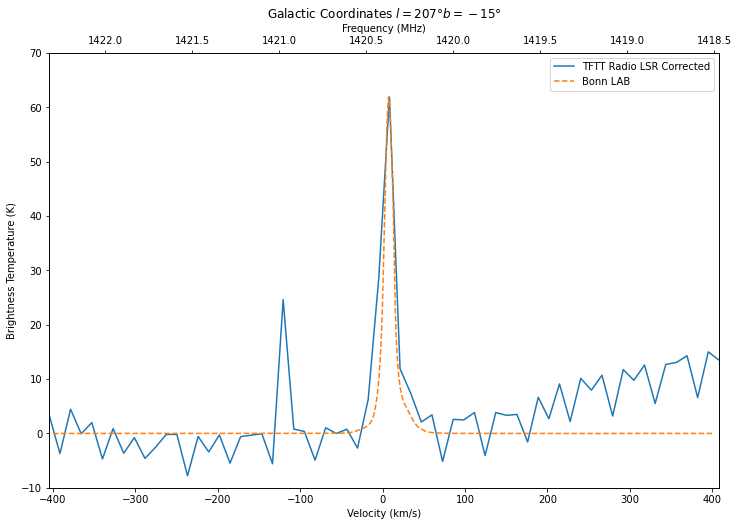

In [8]:
plt.rcParams["figure.figsize"] = [12, 8]
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.set_title('Galactic Coordinates $l=207\degree b=-15\degree$')

ax1.plot(xdatav, np.ones(len(xdatav)), alpha=0) #incorrect placement on plot

ax1.set_xlim([xdatav[low], xdatav[high]])
ax2.set_xlim([xlsr[low], xlsr[high]])
ax1.set_ylim(-10,70)
ax2.set_ylim(-10,70)

ax1.set_xlabel('Velocity (km/s)')
ax1.set_ylabel('Brightness Temperature (K)')
ax2.plot(xlsr,y_calib,label='TFTT Radio LSR Corrected')
ax2.plot(bonn_x,bonn_y, label='Bonn LAB', linestyle='--')
ax2.set_xlabel('Frequency (MHz)')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax2.legend()

# fin